In [296]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

%matplotlib inline

In [297]:
train_data = pd.read_csv("train.csv", sep = ",", header = 0)
test_data = pd.read_csv("test.csv", sep = ",", header = 0)
combined_data = train_data.append(test_data, ignore_index = True)


/usr/local/devel/ANNOTATION/cgreco/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Train Data is split into three columns: id, label, tweet. 

label contains information on whether the tweet is racist, sexist, etc (1) or not (0).
tweet contains the actual text information of the tweet. 


The first step is to define a function to remove any unnecssary information contained within the tweets.

In [298]:
#1. Remove User's mentioned in the tweets-- Anything that starts with "@". 
def remove_pattern(input_txt, pattern):
    return " ".join(list(filter(lambda x:x[0]!=pattern, input_txt.split())))

combined_data["sanitized_tweet"] = np.vectorize(remove_pattern)(combined_data["tweet"], "@")

In [299]:
#2. Remove special punctuation. 
combined_data['sanitized_tweet'] = combined_data['sanitized_tweet'].str.replace("[^a-zA-z#]", " ")

In [300]:
#3. Remove short words and tokenize (put into list of words)
combined_data['sanitized_tweet'] = combined_data['sanitized_tweet'].apply(lambda x: [word for word in x.split() if len(word) > 2])

In [301]:
#Check results of our cleaning
print(combined_data.head())

   id  label                                              tweet  \
0   1    0.0   @user when a father is dysfunctional and is s...   
1   2    0.0  @user @user thanks for #lyft credit i can't us...   
2   3    0.0                                bihday your majesty   
3   4    0.0  #model   i love u take with u all the time in ...   
4   5    0.0             factsguide: society now    #motivation   

                                     sanitized_tweet  
0  [when, father, dysfunctional, and, selfish, dr...  
1  [thanks, for, #lyft, credit, can, use, cause, ...  
2                            [bihday, your, majesty]  
3         [#model, love, take, with, all, the, time]  
4            [factsguide, society, now, #motivation]  


Now we have tokenized, sanitized tweets. We now strip the suffixes of the words to get to the heart of the word in each tokenized tweet. This process is called "Stemming". 

In [302]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

combined_data['sanitized_tweet'] = combined_data['sanitized_tweet'].apply(lambda x: [stemmer.stem(i) for i in x])
print(combined_data.head())


   id  label                                              tweet  \
0   1    0.0   @user when a father is dysfunctional and is s...   
1   2    0.0  @user @user thanks for #lyft credit i can't us...   
2   3    0.0                                bihday your majesty   
3   4    0.0  #model   i love u take with u all the time in ...   
4   5    0.0             factsguide: society now    #motivation   

                                     sanitized_tweet  
0  [when, father, dysfunct, and, selfish, drag, h...  
1  [thank, for, #lyft, credit, can, use, caus, th...  
2                            [bihday, your, majesti]  
3         [#model, love, take, with, all, the, time]  
4                  [factsguid, societi, now, #motiv]  


Now we have stemmed tweets. We can now explore the data to identify trends/patterns between those labeled racist/sexist (1) and not (0).

Let's first look at the hashtag's and see which are associated with each label. 

In [303]:
combined_data['sanitized_tweet'] = combined_data['sanitized_tweet'].apply(lambda x: " ".join(x))

def extract_hashtags(tweets):
    hashtags = []
    for tweet in tweets:
        hashtag = re.findall(r"#(\w+)", tweet)
        hashtags.append(hashtag)
    return hashtags

label1_ht = extract_hashtags(combined_data['sanitized_tweet'][combined_data['label'] == 1])
badHashTags = [item for i in label1_ht for item in i]
label0_ht = extract_hashtags(combined_data['sanitized_tweet'][combined_data['label'] == 0])
goodHashTags = [item for i in label0_ht for item in i]


Now we have a list of each set of hashtags. We can plot the most frequent to see the most common words in each group. 

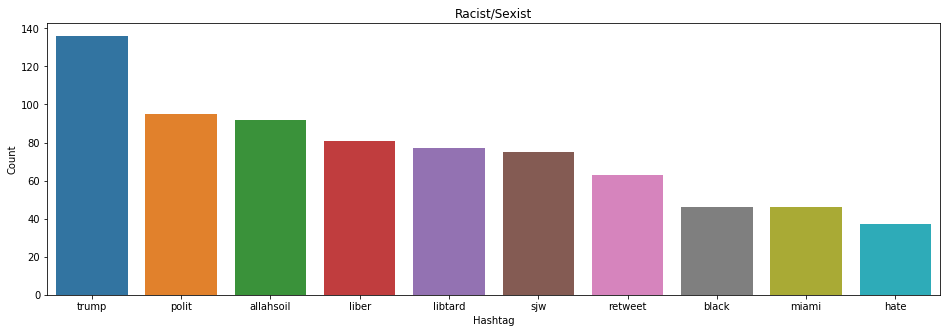

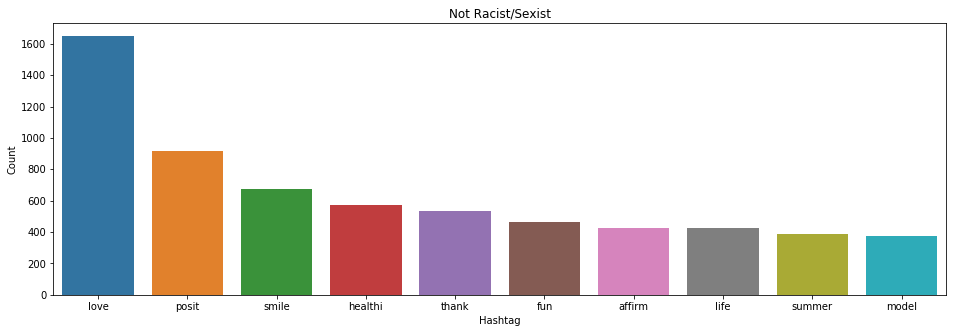

In [304]:
def plot_frequencies(list_of_hashtags, title):
    a = nltk.FreqDist(list_of_hashtags)
    d = pd.DataFrame({'Hashtag': list(a.keys()), 'Count': list(a.values())})
    d = d.nlargest(columns="Count", n = 10) 
    plt.figure(figsize=(16,5))
    ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
    ax.set(ylabel = 'Count', title = title)
    plt.show()

plot_frequencies(badHashTags, "Racist/Sexist")
plot_frequencies(goodHashTags, "Not Racist/Sexist")

Now that we've visualized the hashtags, we can see that they seem to be meaningful. We won't filter them out of the tweets. 

We now have cleaned tweets. We will extract N number of features from the cleaned tweets using several methods to see which performs the best. 

1). Bag-of-Words
2). TF-IDF


In [305]:
#Feature Extraction using Bag-of-Words Features
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df = .8, min_df = 2, max_features=1000, stop_words = 'english')
bow = bow_vectorizer.fit_transform(combined_data['sanitized_tweet'])

In [306]:
#Feature Extraction using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df = 2, max_features = 1000, stop_words = 'english')
tfidf = tfidf_vectorizer.fit_transform(combined_data['sanitized_tweet'])

Now that we have two different sets of feature vectors, we can begin the modeling process. 

In [307]:
#Using Bag-of-Words
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train_data['label'], random_state=42, test_size=0.3)

lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int) # calculating f1 score

/usr/local/devel/ANNOTATION/cgreco/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5571895424836603

In [308]:
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test_data['label'] = test_pred_int
submission = test_data[['id','label']]
submission.to_csv('sub_lreg_bow.csv', index=False) # writing data to a CSV file

In [309]:
#Using TF-IDF
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int)

0.5473321858864029